# 构建神经网络

> 这里主要以新手入门为主来介绍如何构建一个简单的神经网络，并进行测试和优化。

## 1 导入所需包

In [1]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 2 检查GPU是否可用

In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)

Using cuda device
2.2.2+cu121
True
12.1


如果发现GPU不可用，可能是因为torch版本问题（比如我），应该去下载GPU版本。

- 在CUDA官网找到合适版本的[cuda](https://docs.nvidia.com/cuda/cuda-toolkit-release-notes/index.html)，一般是根据系统平台和显卡版本来选择所需CUDA
- 查看安装完成是否
```shell
# 版本，看CUDA的版本，比如我的是cuda_11.2
nvcc --version
# 驱动，看Driver Version
nvidia-smi
```
- 去PyTorch官网找到合适版本的[PyTorch](https://pytorch.org/get-started/previous-versions/)，一般是根据开发环境来选择，然后复制所给的Commond去shell下安装即可
```shell
# 比如我的命令就是
pip install torch==2.2.2 torchvision==0.17.2 torchaudio==2.2.2 --index-url https://download.pytorch.org/whl/cu121
```
- 
> 一张图了解GPU、CUDA、CUDA toolkit和pytorch的关系（待补充）

## 3 定义我们的神经网络
pytorch里面一切自定义操作基本上都是继承`nn.Module`类来实现的，你可以先不去深入了解这个类，但是要知道，我们一般都是通过继承和重构`nn.Module`来定义我们的神经网络。我们一般重构`__init__`和`forward`这两个方法。根据PyTorch官网的说法：`__init__`初始化神经网络层；`forward`层之间的数据操作，也是整个网络的核心。`__init__`只会定义层，而`forward`负责将层连接起来。实际上类的初始化参数一般是一些`固有属性`，我们可以将一些带有训练参数的层放在`__init__`，而没有训练参数的层是可以加入到`forward`里面的，或者说我们将没有训练参数的层看作是层之间的数据操作。

当然直接这么说，肯定不是很清晰，我们来看一个官网给的例子：

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device) # 将网络移入device，并打印结构
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


我们用torchviz可以将神经网络进行一个简单的可视化，当然很多参数可选，这里不一一列举
```shell
pip install torchviz
``` 

In [9]:
from torchviz import make_dot
X = torch.rand(1, 28, 28, device=device) # 需要对神经网络进行数据输入，才是一个完整的网络
y = model(X)
output = make_dot(y.mean(), params=dict(model.named_parameters())) # 开始绘制
output.format = "png"
output.directory = "."
output.render("torchviz", view=True) # 会在相对路径下保存一个可视化后的图片并打开

'torchviz.png'

看起来可能会比较复杂，也看不懂，我们得需要学会看懂神经网络的结构才能看懂结构图。当然，还有诸如draw_convnet、NNSVG、netron等可视化工具会更加优秀。

## 4 神经网络模型层

想要构建一个神经网络并进行训练和预测，我们需要去认识神经网络的构成。假定你已经了解过感知机、人工神经网络的基本概念，那么现在就是来了解一下神经网络的模型层。

我们直接分解一下官网所给出的这个模型，这是一个简单的前馈神经网络（Feedforward Neural Network），我们先不去了解它的作用，一点点的分解它，看看它最终实现了什么。

我们先根据官网所说的，取一个大小为 28x28 的 3 张图像的样本小批量作为输入（我们一般将数据的第一个维度看作批量维度并保留）：

In [5]:
input_image = torch.rand(3,28,28)
print(input_image.size())

torch.Size([3, 28, 28])


### 4.1 nn.Flatten
虽然是PyTorch的`nn.Flatten`，但是Flatten层是神经网络中常见的组成部分。在神经网络的训练和预测过程中，输入数据通常需要经过一系列的处理和转换。在这个过程中，Flatten层能够将多维的输入数据转化为一维的线性形式，以便于神经网络的进一步处理。模型中的`nn.Flatten`，将我们所输入的2D $28\times28$ 图像转换为一个包含 784 个像素值的连续数组，也就是和它表面的意思一样展平这个高维数组。
> （`nn.Flatten()`默认参数是`start_dim=1`和`end_dim=-1`，如果你想展平所有维度，可以通过设置`start_dim=0`来实现）

In [6]:
flatten = nn.Flatten()
flat_image = flatten(input_image) # 将输入的图像展平
print(flat_image.size())

torch.Size([3, 784])


在卷积神经网络（CNN）中，`Flatten`层可以将卷积层提取到的特征图展平，便于进一步的特征处理或分类，也便于输入到全连接层（全连接层通常需要一维的输入，后面会讲到）。在构建复杂网络时，`Flatten`层可以帮助不同类型的层之间进行连接。总的来说，`Flatten`层起到了桥梁的作用，使得卷积神经网络的层次结构更加灵活和易于设计，并且确保了从卷积层到全连接层的数据传递顺畅，维持了网络的整体性能和效率。

### 4.2 nn.Linear
`nn.Linear`应该耳熟能详，我们称之为线性层（Linear Layer），也可以称为全连接层（Fully Connected Layer）或密集层（Dense Layer）。线性层是一个使用其存储的权重和偏差对输入应用线性变换的模块，也就是对输入数据进行线性变换。线性层对数据的处理方式基本上可以表示为：$y = Wx + b$，其中$W$权重矩阵和$b$偏置向量都是可学习的参数。在神经网络的训练和预测过程中，`Linear`层的作用是将输入数据通过一组权重进行线性变换，然后添加一个偏置项。简单来说，它能够将输入特征映射到输出特征，从而实现对数据的线性组合和转换。如下图是一个单隐藏层的多层感知机（Multilayer Perceptron），一般称为MLP，隐藏层和输出层均是由线性层和激活函数组成：

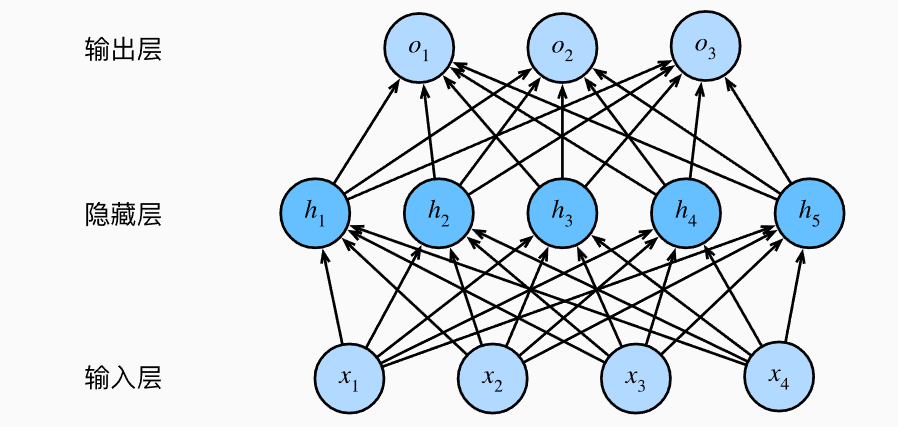

In [10]:
# 定义一个线性层，将28*28维度的向量转换为20维度的向量
layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image) 
print(hidden1.size())

torch.Size([3, 20])


> 在这个例子中，in_features=28*28表示输入特征的维度，out_features=20表示输出特征的维度。nn.Linear层会自动初始化权重和偏置，并在训练过程中通过**反向传播算法**进行调整。简单理解就是，该线性层的输入是784维，而输出是20维。

### 4.3 nn.ReLU
ReLU函数，全称Rectified Linear Unit，是人工神经网络中常用的一种激活函数.
讲到这里，我们就讲讲常见的激活函数及其作用。

#### Sigmoid 激活函数

**数学表达式：**
$ \sigma(x) = \frac{1}{1 + e^{-x}} $

**作用：**
- 将输入映射到 (0, 1) 之间。
- 常用于输出层，尤其是在二分类问题中，输出概率值。

**优点：**
- 输出范围在 (0, 1) 之间，可以解释为概率。
- 平滑梯度，有助于梯度下降。

**缺点：**
- 容易导致梯度消失问题。
- 输出不是零中心的，会影响网络的训练效率。


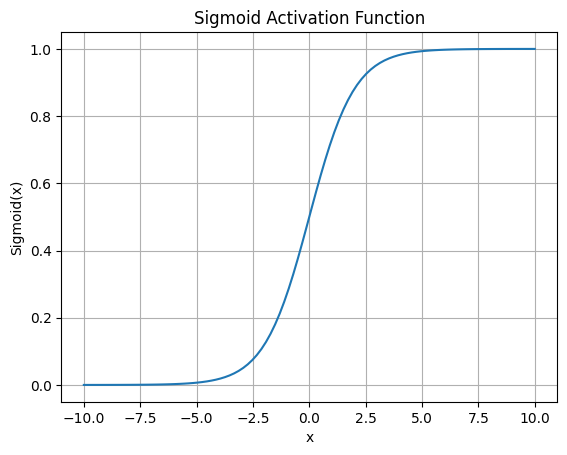

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.linspace(-10, 10, 100)
y = sigmoid(x)

plt.plot(x, y)
plt.title("Sigmoid Activation Function")
plt.xlabel("x")
plt.ylabel("Sigmoid(x)")
plt.grid()
plt.show()

#### Tanh 激活函数

**数学表达式：**
$ \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} $

**作用：**
- 将输入映射到 (-1, 1) 之间。
- 常用于隐藏层，提供零中心的输出，有助于训练。

**优点：**
- 输出是零中心的，梯度消失问题较轻。

**缺点：**
- 仍然存在梯度消失问题。


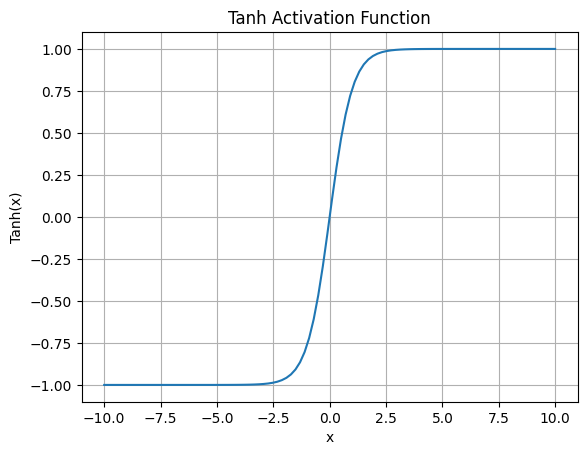

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def tanh(x):
    return np.tanh(x)

x = np.linspace(-10, 10, 100)
y = tanh(x)

plt.plot(x, y)
plt.title("Tanh Activation Function")
plt.xlabel("x")
plt.ylabel("Tanh(x)")
plt.grid()
plt.show()

#### ReLU (Rectified Linear Unit) 激活函数

**数学表达式：**
$ \text{ReLU}(x) = \max(0, x) $

**作用：**
- 将输入小于0的部分设为0，大于0的部分保持不变。
- 常用于隐藏层，特别是深度神经网络。

**优点：**
- 计算简单，收敛速度快。
- 减少梯度消失问题。

**缺点：**
- 输出不是零中心的。
- 输入小于0时梯度为零，可能导致“神经元死亡”问题。


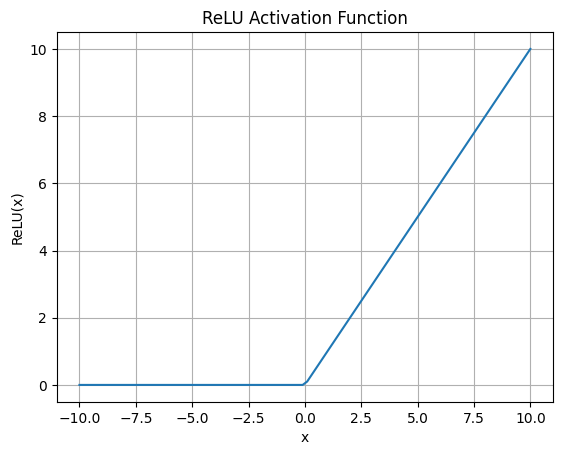

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

x = np.linspace(-10, 10, 100)
y = relu(x)

plt.plot(x, y)
plt.title("ReLU Activation Function")
plt.xlabel("x")
plt.ylabel("ReLU(x)")
plt.grid()
plt.show()

#### Leaky ReLU 激活函数

**数学表达式：**
$ \text{Leaky ReLU}(x) = \begin{cases} 
      x & \text{if } x > 0 \\
      \alpha x & \text{if } x \leq 0 
   \end{cases}
$
其中 \(\alpha\) 通常是一个很小的常数，如 0.01。

**作用：**
- 解决 ReLU 的“神经元死亡”问题。

**优点：**
- 输入小于0时仍有较小梯度，避免神经元死亡。

**缺点：**
- 计算稍复杂。


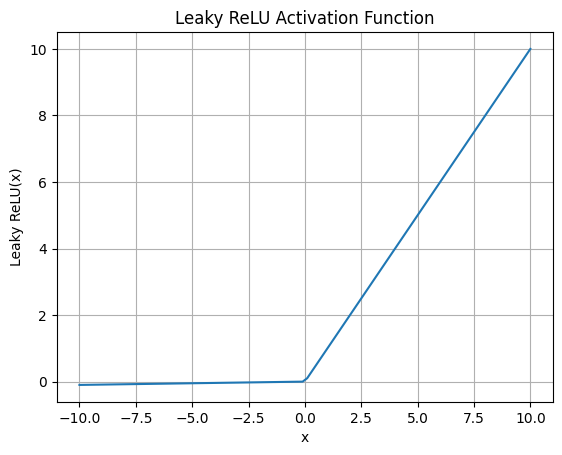

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

x = np.linspace(-10, 10, 100)
y = leaky_relu(x)

plt.plot(x, y)
plt.title("Leaky ReLU Activation Function")
plt.xlabel("x")
plt.ylabel("Leaky ReLU(x)")
plt.grid()
plt.show()

#### Softmax 激活函数

**数学表达式：**
$ \text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}} $

**作用：**
- 将输入向量转换为概率分布，总和为1。
- 常用于多分类问题的输出层。

**优点：**
- 输出可以解释为概率，便于分类。

**缺点：**
- 计算相对复杂，容易导致数值不稳定。


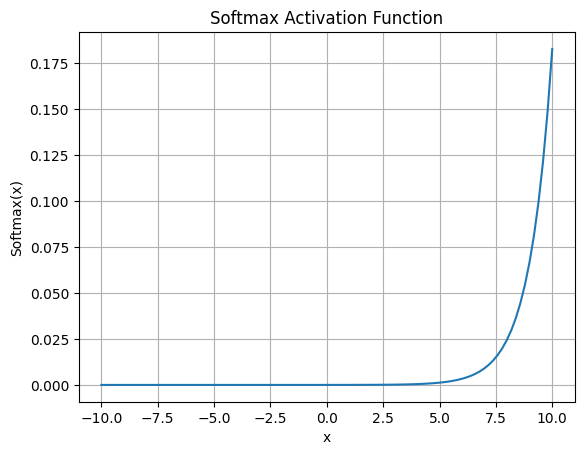

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

x = np.linspace(-10, 10, 100)
y = softmax(x)

plt.plot(x, y)
plt.title("Softmax Activation Function")
plt.xlabel("x")
plt.ylabel("Softmax(x)")
plt.grid()
plt.show()


### 4.4 nn.Sequential
`nn.Sequential`是 PyTorch 提供的一个容器模块，它按顺序包含其他子模块，便于构建和管理简单的神经网络结构。通过 nn.Sequential，可以方便地将一系列层（如线性层、激活函数、卷积层等）按顺序堆叠在一起，从而简化模型定义和前向传播的代码。简而言之就是一个包裹的顺序容器。

## 5 理解我们的神经网络
看完这些，我们再来理解这个官网给的例子：

In [19]:
class NeuralNetwork(nn.Module):
    # 重构 __init__，定义“固有属性”
    def __init__(self):
        # 这一步操作是调用父类 nn.Module 的构造函数，确保继承自 nn.Module 的特性正确初始化
        super().__init__()
        # 定义一个展开层 flatten
        self.flatten = nn.Flatten()
        # 定义一个线性容器，可以简化在forward中的调用
        self.linear_relu_stack = nn.Sequential(
            # 容器内包含一个三层网络
            # 这里的512、10都是研究者根据具体任务和数据集进行调试和优化得到的结果
            # 熟悉的调参
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
    # 重构forward，定义前向传播路径
    def forward(self, x):
        # 在这里定义各个层输入输出的顺序，即层在网络里的位置关系
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
model = NeuralNetwork().to(device) # 将网络移入device，并打印结构
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 6 使用我们的网络

主要步骤如下：
- 定义模型
- 数据载入
- 损失函数和优化
- 训练和评估
- 预测与可视化

先导入所需包：

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

### 6.1 定义模型

In [24]:
# 定义设备，如果有GPU则使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义神经网络模型
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# 创建神经网络模型实例，并移动到设备上
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### 6.2 数据载入
我们这次用的模型用于简单图像分类问题，所以可以使用[MNIST数据集](https://paperswithcode.com/dataset/mnist)，导入用的是PyTorch的[datasets](https://pytorch.org/vision/stable/datasets.html)。

In [25]:
# 加载MNIST数据集并进行预处理
transform = transforms.Compose([
    # 对图片的常用操作，将图像数据转换为形状为 (C, H, W) 的张量
    transforms.ToTensor(),
    # 因为数据集是灰度图像，所以只有单值标准化
    transforms.Normalize((0.5,), (0.5,))
])

# 加载MNIST数据集，并划分训练集和测试集（这里会下载下来）
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform)

# 定义批量大小和数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 6.3 损失函数和优化
损失函数选取交叉熵损失函数（Cross Entropy Loss），它是一种常用的损失函数，能够有效地衡量预测类别和真实类别之间的差异。它能够处理模型输出的logits，并且在计算过程中会自动应用Softmax操作，从而简化代码。

优化器选取随机梯度下降法（Stochastic Gradient Descent, SGD），它是一种简单而有效的优化方法，特别适用于大规模数据集和模型。结合Momentum算法，SGD优化器可以加速收敛并减小震荡，从而在一定程度上提高训练效率和模型性能。

In [27]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()
# 定义优化器
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### 6.4 训练和评估

In [29]:
# 训练模型
# 训练的目的是通过多个训练周期和批次的数据，不断调整模型参数以最小化损失函数，从而提高模型的性能。
def train(model, train_loader, optimizer, criterion, epochs=5):
    # 某些层（如Dropout和BatchNorm）在训练和评估模式下的行为不同，所以需要显式地设置模型为训练模式。
    model.train()
    # 开始训练循环
    for epoch in range(epochs):
        # 初始化损失
        running_loss = 0.0
        # 遍历训练数据加载器中的每个批次
        for batch_idx, (data, target) in enumerate(train_loader):
            # 将数据移动到设备上
            data, target = data.to(device), target.to(device)
            # 梯度清零
            optimizer.zero_grad()
            # 前向传播，将数据输入模型进行预测
            output = model(data)
            # 计算损失
            loss = criterion(output, target)
            # 将损失反向传播
            loss.backward()
            # 使用优化器更新参数
            optimizer.step() 
            # 累计损失
            running_loss += loss.item()
            if batch_idx % 100 == 99:    # 每100个批次打印一次训练状态
                print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0

# 测试模型
def test(model, test_loader):
    # 进入评估模式，原因与train同理
    model.eval()
    # 累计计数
    correct = 0
    total = 0
    # 测试过程不会进行优化，所以no_grad禁用梯度计算可以加快测试速度
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            # 前向传播，将数据输入模型进行预测
            outputs = model(data)
            # 获取预测结果
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

### 6.5 预测与可视化

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch [1/5], Step [100/938], Loss: 1.1812
Epoch [1/5], Step [200/938], Loss: 0.4243
Epoch [1/5], Step [300/938], Loss: 0.3437
Epoch [1/5], Step [400/938], Loss: 0.3305
Epoch [1/5], Step [500/938], Loss: 0.2820
Epoch [1/5], Step [600/938], Loss: 0.2634
Epoch [1/5], Step [700/938], Loss: 0.2482
Epoch [1/5], Step [800/938], Loss: 0.2131
Epoch [1/5], Step [900/938], Loss: 0.2161
Epoch [2/5], Step [100/938], Loss: 0.1853
Epoch [2/5], Step [200/938], Loss: 0.1658
Epoch [2/5], Step [300/938], Loss: 0.1766
Epoch [2/5], Step [400/938], Loss: 0.1507
Epoch [2/5], Step [500/938], Loss: 0.1606
Epoch [2/5], Step [600/938], Loss: 0.1347
Epoch [2/5], Step [700/938], Loss: 0.1407
Epoch [2/

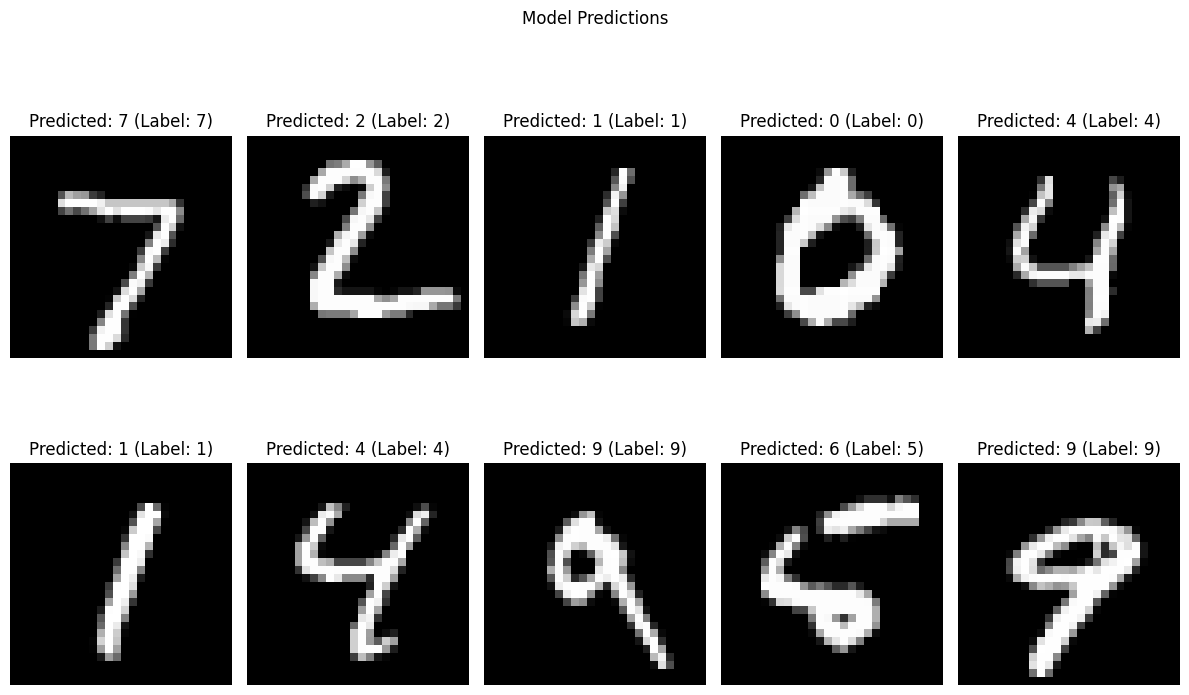

In [21]:
# 可视化预测结果
def visualize_predictions(model, test_loader, num_images=10):
    # 这里和上面定义的test相似，主要是在执行过程中添加了可视化代码和限制了测试数量
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(12, 8))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            # 获取每张图的预测结果，并将数据绘制出来进行比对
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 5, 5, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {preds[j]} (Label: {labels[j]})')
                # imshow用于在绘图窗口中显示图像
                ax.imshow(inputs.cpu().data[j].numpy().squeeze(), cmap='gray')
                if images_so_far == num_images:
                    model.train()
                    return
        model.train()

# 执行训练
train(model, train_loader, optimizer, criterion)

# 执行测试
test(model, test_loader)

# 可视化预测结果
visualize_predictions(model, test_loader, num_images=10)
plt.suptitle('Model Predictions')
plt.tight_layout()
plt.show()


神经网络（尤其是深度神经网络）的一个非常吸引人的特点就是：它们具有很强的通用性，可以通过不同的数据集进行训练，以解决各种不同的任务。我们可以将该模型使用另外的数据集进行训练和测试，仍然有不低的准确率。

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch [1/5], Step [100/938], Loss: 1.1111
Epoch [1/5], Step [200/938], Loss: 0.6047
Epoch [1/5], Step [300/938], Loss: 0.5097
Epoch [1/5], Step [400/938], Loss: 0.4919
Epoch [1/5], Step [500/938], Loss: 0.4808
Epoch [1/5], Step [600/938], Loss: 0.4519
Epoch [1/5], Step [700/938], Loss: 0.4558
Epoch [1/5], Step [800/938], Loss: 0.4473
Epoch [1/5], Step [900/938], Loss: 0.4138
Epoch [2/5], Step [100/938], Loss: 0.3960
Epoch [2/5], Step [200/938], Loss: 0.3889
Epoch [2/5], Step [300/938], Loss: 0.4075
Epoch [2/5], Step [400/938], Loss: 0.3719
Epoch [2/5], Step [500/938], Loss: 0.3819
Epoch [2/5], Step [600/938], Loss: 0.3858
Epoch [2/5], Step [700/938], Loss: 0.3838
Epoch [2/

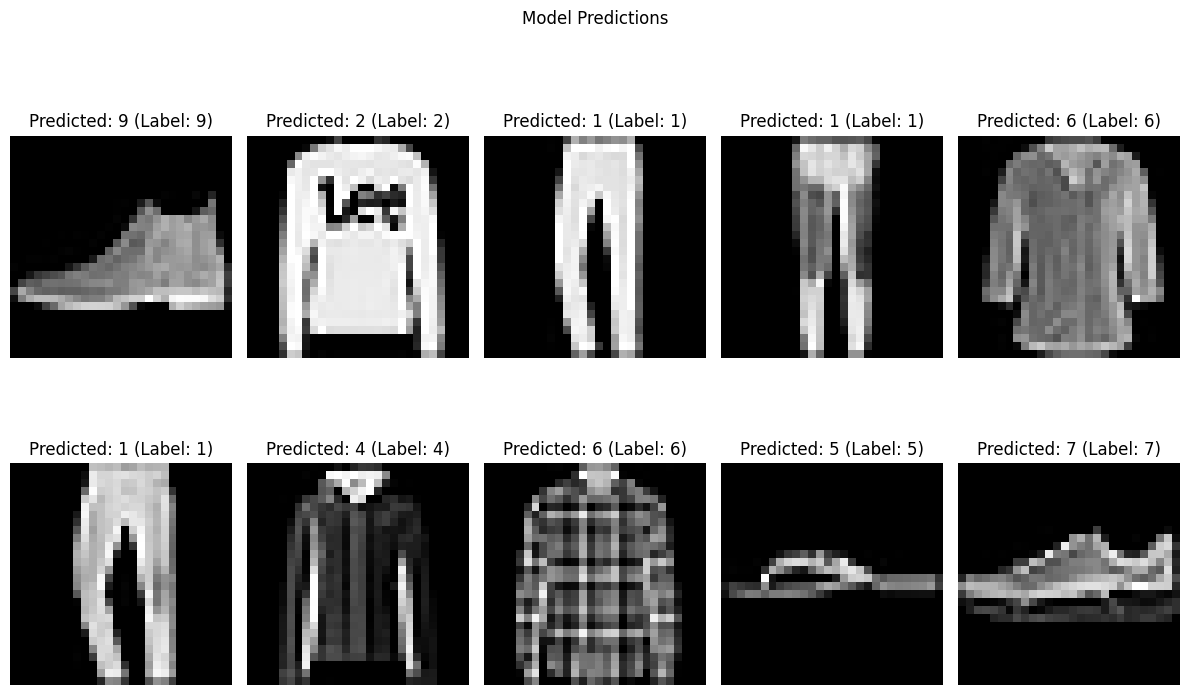

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# 定义设备，如果有GPU则使用GPU，否则使用CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义神经网络模型
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# 创建神经网络模型实例，并移动到设备上
model = NeuralNetwork().to(device)
print(model)

# 加载FashionMNIST数据集并进行预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform)

# 定义批量大小和数据加载器
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
def train(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 100 == 99:    # 每100个批次打印一次训练状态
                print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0

# 测试模型
def test(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# 可视化预测结果
def visualize_predictions(model, test_loader, num_images=10):
    model.eval()
    images_so_far = 0
    plt.figure(figsize=(12, 8))
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size(0)):
                images_so_far += 1
                ax = plt.subplot(num_images // 5, 5, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {preds[j]} (Label: {labels[j]})')
                ax.imshow(inputs.cpu().data[j].numpy().squeeze(), cmap='gray')
                if images_so_far == num_images:
                    model.train()
                    return
        model.train()

# 执行训练
train(model, train_loader, optimizer, criterion)

# 执行测试
test(model, test_loader)

# 可视化预测结果
visualize_predictions(model, test_loader, num_images=10)
plt.suptitle('Model Predictions')
plt.tight_layout()
plt.show()


## 7 优化与调参
显然，同样的模型对于不同的数据集的适配程度是不一样的。对于MNIST数据集准确率可以达到97%，但对于FashionMNIST只能达到86%。所以我们可以来探索一下为什么会有这样的偏差，以及如何优化该模型才能让FashionMNIST也可以达到90%以上的准确率。

### 7.1 可能的问题

1. 数据集的复杂性

- MNIST 数据集：包含手写数字的灰度图像（0-9），这些图像相对简单，特征明显，模式较少。
- FashionMNIST 数据集：包含服装物品的灰度图像（例如 T 恤、裤子、鞋子等），这些图像的特征更加复杂，类别之间的差异较小。

2. 模型的复杂性

- 我们使用的是一个简单的全连接神经网络，它可能足以在 MNIST 数据集上达到高准确率，但在处理更复杂的 FashionMNIST 数据集时会表现不佳。

3. 超参数调整：

- 我们的模型可能需要在不同的数据集上进行不同的超参数调整。例如，学习率、批量大小、正则化参数等可能需要重新调整以适应 FashionMNIST 的复杂性。

4. 数据预处理：

- 数据的预处理步骤（如标准化、归一化、数据增强等）对不同的数据集可能有不同的效果。我们可能需要针对 FashionMNIST 数据集尝试不同的预处理方法。

### 7.2 解决方案

#### 7.2.1 增加神经网络层数和神经元容量
通过增加模型的容量，模型能够学习更多的特征。如下，我们添加两个线性层进一步提高模型对复杂特征的处理能力。

In [ ]:
class NeuralNetwork_v1(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

可能因为线性层在处理FashionMNIST数据集时，难以处理和学习更多的特征，在添加了线性层后预测准确率没有明显的提高，仍然是87%左右。所以需要尝试其他的方法。

#### 7.2.2  使用卷积神经网络（CNN）
FashionMNIST 数据集涉及到服装和配件的图像分类，每个图像都是单通道的灰度图像，分辨率为 28x28 像素。尽管 FashionMNIST 数据集相对于真实世界的图像数据集如 CIFAR-10 或 ImageNet 来说较为简单，但仍然涉及到一定程度的空间特征。且如纹理图案、形状轮廓等复杂特征，线性层更加难以处理和识别。所以在局部相关性和空间结构处理占优的情况下，使用卷积神经网络（CNN）来处理是更优的选择。




Epoch [1/5], Step [100/938], Loss: 0.7875
Epoch [1/5], Step [200/938], Loss: 0.4787
Epoch [1/5], Step [300/938], Loss: 0.4455
Epoch [1/5], Step [400/938], Loss: 0.3960
Epoch [1/5], Step [500/938], Loss: 0.3657
Epoch [1/5], Step [600/938], Loss: 0.3557
Epoch [1/5], Step [700/938], Loss: 0.3363
Epoch [1/5], Step [800/938], Loss: 0.3495
Epoch [1/5], Step [900/938], Loss: 0.3140
Epoch [2/5], Step [100/938], Loss: 0.2842
Epoch [2/5], Step [200/938], Loss: 0.3065
Epoch [2/5], Step [300/938], Loss: 0.2671
Epoch [2/5], Step [400/938], Loss: 0.2750
Epoch [2/5], Step [500/938], Loss: 0.2874
Epoch [2/5], Step [600/938], Loss: 0.2722
Epoch [2/5], Step [700/938], Loss: 0.2639
Epoch [2/5], Step [800/938], Loss: 0.2840
Epoch [2/5], Step [900/938], Loss: 0.2630
Epoch [3/5], Step [100/938], Loss: 0.2359
Epoch [3/5], Step [200/938], Loss: 0.2461
Epoch [3/5], Step [300/938], Loss: 0.2350
Epoch [3/5], Step [400/938], Loss: 0.2337
Epoch [3/5], Step [500/938], Loss: 0.2453
Epoch [3/5], Step [600/938], Loss:

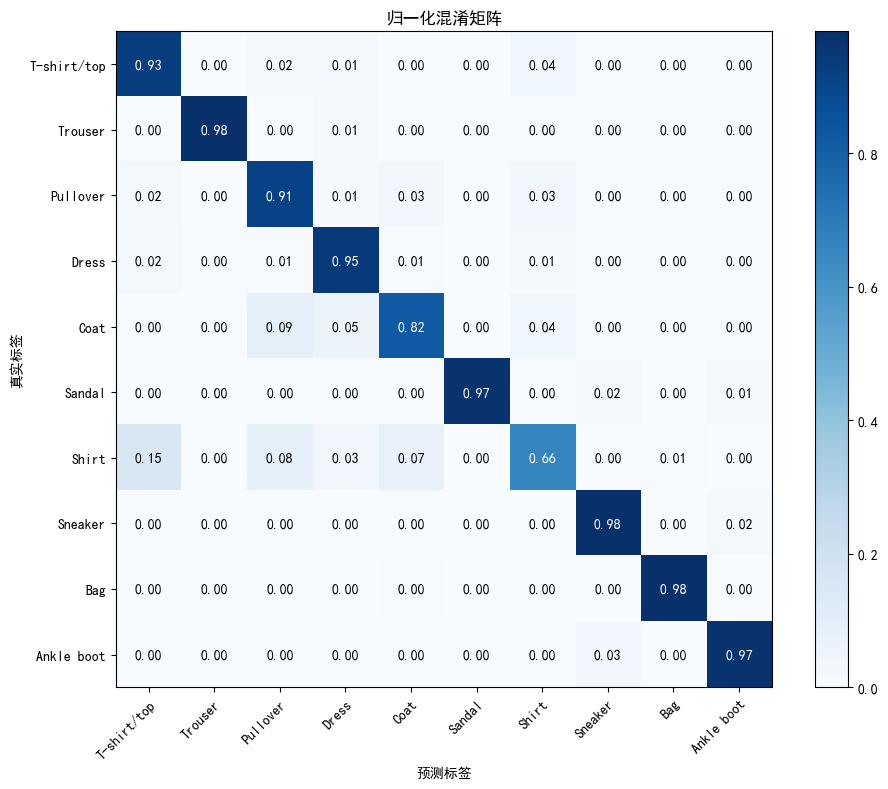

<Figure size 640x480 with 0 Axes>

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvNeuralNetwork(nn.Module):
    def __init__(self):
        super(ConvNeuralNetwork, self).__init__()
        # 卷积层定义
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # 扁平化层
        self.flatten = nn.Flatten()
        # 全连接层
        self.fc1 = nn.Linear(128*3*3, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, 10)
        # Dropout 正则化层，用于随机丢弃一定比例的神经元，防止过拟合
        self.dropout = nn.Dropout(0.4)
        # 批量归一化层，对每个卷积层的输出进行归一化，有助于加速收敛和提高模型泛化能力
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        # 批量归一化层，对全连接层的输出进行归一化
        self.batch_norm_fc1 = nn.BatchNorm1d(512)
        self.batch_norm_fc2 = nn.BatchNorm1d(512)

    def forward(self, x):
        # 卷积层和激活函数
        # 依次进行卷积、ReLU 激活函数、批量归一化和最大池化操作

        x = self.conv1(x)
        x = F.relu(self.batch_norm1(x))
        x = F.max_pool2d(x, 2)
        
        x = self.conv2(x)
        x = F.relu(self.batch_norm2(x))
        x = F.max_pool2d(x, 2)
        
        x = self.conv3(x)
        x = F.relu(self.batch_norm3(x))
        x = F.max_pool2d(x, 2)
        
        # 进行全连接和正则化
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(self.batch_norm_fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = F.relu(self.batch_norm_fc2(x))
        x = self.dropout(x)
        
        # 输出层
        logits = self.fc3(x)
        return logits



# 创建CNN实例，并移动到设备上
model_v1 = ConvNeuralNetwork().to(device)

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_v1.parameters(), lr=0.01, momentum=0.9)

# train_loader、test_loader 在之前已初始化

# 训练模型
def train_v1(model, train_loader, optimizer, criterion, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if batch_idx % 100 == 99:    # 每100个批次打印一次训练状态
                print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {running_loss/100:.4f}')
                running_loss = 0.0

# 获取类别名称
class_names_v1 = train_dataset.classes

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用SimHei字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题

def visualize_predictions_v1(model, dataloader, class_names):
    model.eval()
    num_classes = len(class_names)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # 将数据移动到设备上
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
    
    # 归一化混淆矩阵
    confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
    
    # 绘图
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(confusion_matrix.shape[1]),
           yticks=np.arange(confusion_matrix.shape[0]),
           xticklabels=class_names, yticklabels=class_names,
           title='归一化混淆矩阵',
           ylabel='真实标签',
           xlabel='预测标签')

    # 旋转标签并设置对齐
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # 遍历数据维度并创建文本注释
    fmt = '.2f'
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(j, i, format(confusion_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if confusion_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

# 执行训练
train_v1(model_v1, train_loader, optimizer, criterion)

# 执行测试
test(model_v1, test_loader)

# 可视化预测结果
visualize_predictions_v1(model_v1, test_loader, class_names_v1)
plt.suptitle('Model Predictions_v1')
plt.tight_layout()
plt.show()


#### 7.2.3 调整超参数

超参数是模型训练过程中需要预先设定的参数，学习率、批次大小和迭代次数等都称之为超参数。通过调整这些超参数，我们可以提高模型的性能和准确性。

- 学习率是最重要的超参数之一。我们可以尝试不同的学习率，观察其对模型性能的影响：

In [ ]:
learning_rates = [0.1, 0.01, 0.001]

for lr in learning_rates:
    optimizer = optim.SGD(model.parameters(), lr=lr)
    # 训练模型并记录性能


- 当然我们还可以通过学习率调度器在训练过程中动态调整学习率

In [ ]:
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(num_epochs):
    # 训练模型
    scheduler.step()


- 批量大小会影响训练的稳定性和速度：

In [ ]:
batch_sizes = [32, 64, 128]

for batch_size in batch_sizes:
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    # 训练模型并记录性能


- 不同的优化器可能会对模型的收敛速度和最终性能产生影响。我们可以尝试不同的优化器，如SGD和Adam：

In [ ]:
optimizers = {
    'SGD': optim.SGD(model.parameters(), lr=0.01),
    'Adam': optim.Adam(model.parameters(), lr=0.01)
}

# 参考
- [PyTorch-构建神经网络](https://pytorch.ac.cn/tutorials/beginner/basics/buildmodel_tutorial.html)
- [PyTorch中文文档](https://pytorch-cn.readthedocs.io/zh/latest/package_references/torch-nn/)
- [d2L-多层感知机](https://zh.d2l.ai/chapter_multilayer-perceptrons/mlp.html)